Baseline Deteksi Ujaran Kebencian Metode BiGru 

Copyright@ I Gde Bagus Janardana Abasan 

In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from keras.preprocessing.text import Tokenizer
# from keras.preprocessing.sequence import pad_sequences
from keras.utils import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Dropout, Embedding, Bidirectional, AveragePooling1D, LSTM, GRU, Conv1D, MaxPooling1D, Flatten, GlobalMaxPooling1D, CuDNNGRU , GlobalAveragePooling1D, Concatenate, TimeDistributed
from keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report
from sklearn.metrics import precision_score, accuracy_score, recall_score, f1_score
from keras.wrappers.scikit_learn import KerasClassifier
from keras.optimizers import Adam, SGD, RMSprop, Adagrad, Adadelta, Adamax, Nadam
from keras import regularizers
import tensorflow as tf
import matplotlib.pyplot as plt

In [2]:
# check tensorflow version
# 2.9.1 untuk version paperspace
# 2.11 untuk collab
print(tf.__version__)

2.9.3


## BIGRU MODEL BASELINE
1. TF-IDF max features
2. Test Size

Expected Result : 
1. test-size yang bagus untuk model ini.

In [3]:
# Menampilkan informasi perangkat GPU yang digunakan
physical_devices = tf.config.list_physical_devices('GPU')
for device in physical_devices:
    device_details = tf.config.experimental.get_device_details(device)
    print(device_details)

try:
    print(f'Found {physical_devices[0]} GPU(s)')
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
    assert tf.config.experimental.get_memory_growth(physical_devices[0])
    print('Memory growth set to True, using Nvidia Tesla T4')
except:
    print('Failed to set memory growth to True')
    pass

{'compute_capability': (7, 5), 'device_name': 'Tesla T4'}
Found PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU') GPU(s)
Memory growth set to True, using Nvidia Tesla T4


In [4]:
def process_data(test_size, max_features):
  dataset = pd.read_csv('../../data/data_preprocessed/dataset/DatasetHateSpeech_Final_TA2023.csv', usecols=['preprocess_final', 'preprocess_token', 'label_final'])
  # make data['label_fase_1'] to 0 and 1 binary classifier karena tensor hanya bisa input 0 =< label =< 1
  dataset['label_final'] = dataset['label_final'].apply(lambda x: 1 if x == 'HS' else 0)
  dataset.dropna(inplace=True)
  
  # feature extration
  # Create a CountVectorizer object and fit it to the training data
  vectorizer = TfidfVectorizer(ngram_range=(1,1), max_features=max_features)
  vectorizer_data = vectorizer.fit_transform(dataset['preprocess_final'])

  # to_pd
  x_final = pd.DataFrame(vectorizer_data.toarray(), columns=vectorizer.get_feature_names_out())
  y_final = dataset['label_final'].copy()

  # split
  X_train, X_test, y_train, y_test = train_test_split(x_final, y_final, test_size=test_size, random_state=0)
  return X_train, X_test, y_train, y_test

In [5]:
def create_bigru_model(X_train, y_train, X_test, y_test, units):
  # reshape# reshape train and test data
  X_train = np.array(X_train).reshape(X_train.shape[0], 1, X_train.shape[1])
  X_test = np.array(X_test).reshape(X_test.shape[0], 1, X_test.shape[1])

  # create sequential model
  model = Sequential()
  model.add(Bidirectional(GRU(units, input_shape=(X_train.shape), activation='relu', return_sequences=True)))
  model.add(GlobalMaxPooling1D())
  model.add(Dense(units = 32, activation='relu'))
  model.add(Dense(units = 1, activation='sigmoid'))

  opt = Adam(learning_rate=0.00005)
  model.compile(optimizer=opt, loss = 'binary_crossentropy', metrics=['accuracy'])

  input_shape = X_train.shape
  model.build(input_shape)
  model.summary()
  print()

  with tf.device('/cpu:0'):
    x = tf.convert_to_tensor(X_train, np.float32)
    y = tf.convert_to_tensor(y_train, np.float32)

  model.fit(x, y, epochs=10, batch_size = 128, validation_data = (X_test, y_test))
  loss = model.history.history['loss']
  val_loss = model.history.history['val_loss']
  score = model.evaluate(X_test, y_test, batch_size=128, verbose=0)
  print()
  print('Validation Accuracy:', score[1])
  print('Validation Loss:', score[0])
  print()

  return model, loss, val_loss

###  Test Size

In [6]:
def call(test_size, max_features):
  X_train, X_test, y_train, y_test = process_data(test_size, max_features)
  model, loss, val_loss = create_bigru_model(X_train, y_train, X_test, y_test, 32)
  # predict
  X_test = np.array(X_test).reshape(X_test.shape[0], 1, X_test.shape[1])
  
  y_pred = model.predict(X_test)
  print('using test size :', test_size)
  print()

  # confusion matrix
  classreport = classification_report(y_test, y_pred.round(), digits=4)
  print()
  print(classreport)
  print()
  accscore = accuracy_score(y_test, y_pred.round())
  precscore = precision_score(y_test, y_pred.round(), zero_division=0)
  recscore = recall_score(y_test, y_pred.round())
  f1score = f1_score(y_test, y_pred.round(), average='weighted', zero_division=0)

  return [accscore, precscore, recscore, f1score, loss, val_loss]

In [7]:
test_size = [0.2]
max_features = [5000, 10000, 15000]
result = []
count = 1
for idx, value_testsize in enumerate(test_size):
  for idx_max, value_features in enumerate(max_features):
    for i in range(5):
      result.append([count] + [value_testsize] + [value_features] + call(value_testsize, value_features))
      count += 1

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional (Bidirectiona  (39872, 1, 64)           966528    
 l)                                                              
                                                                 
 global_max_pooling1d (Globa  (39872, 64)              0         
 lMaxPooling1D)                                                  
                                                                 
 dense (Dense)               (39872, 32)               2080      
                                                                 
 dense_1 (Dense)             (39872, 1)                33        
                                                                 
Total params: 968,641
Trainable params: 968,641
Non-trainable params: 0
_________________________________________________________________

Epoch 1/10
312/312 [=============================

In [8]:
def loss_func(df):
  # plot loss function rata-rata
  # plot loss function
  for idx, val in enumerate(df['No']):
    plt.plot(df['Loss'].iloc[idx], label=f'Test Size {val} ke {idx+1}')
    plt.plot(df['Val Loss'].iloc[idx], label=f'Test Size {val} ke {idx+1}')
    plt.title(f'loss function test size {df["Test_Size"].iloc[idx]} max_features {df["Max_Features"].iloc[idx]}')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper right')
    plt.savefig(f'hasil/grafik/bigru/lfg_baselineBiGRU_testSize{df["Test_Size"].iloc[idx]}-max_features{df["Max_Features"].iloc[idx]}.png')
    plt.show()
    plt.clf()

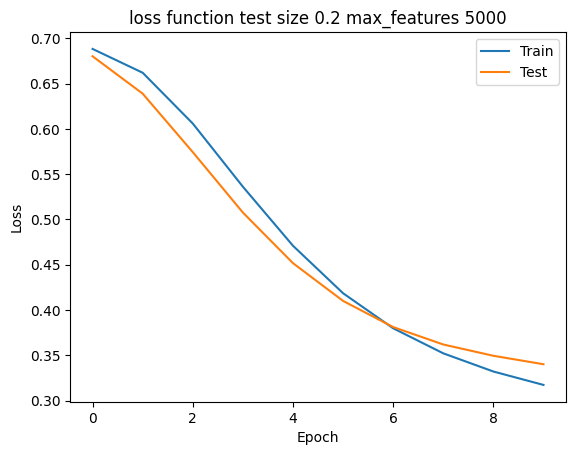

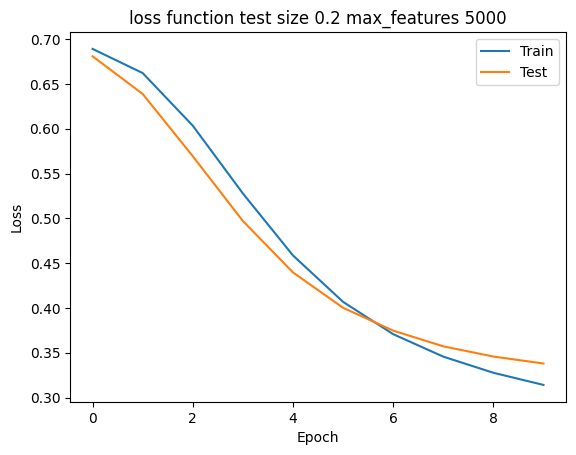

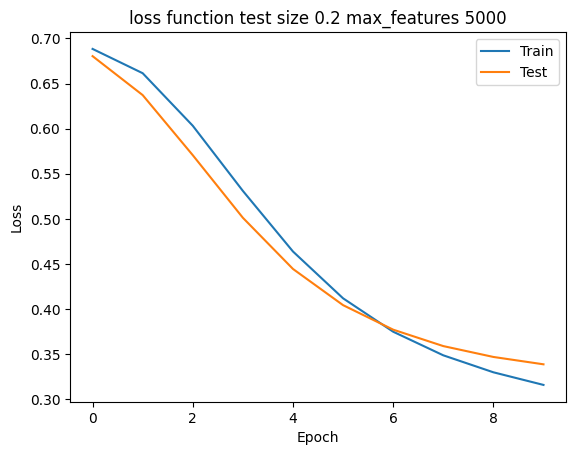

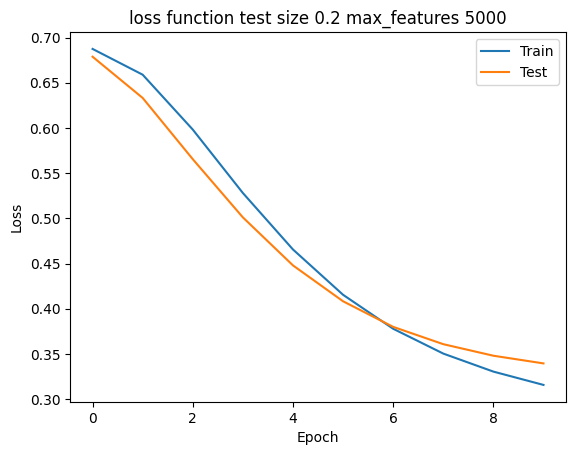

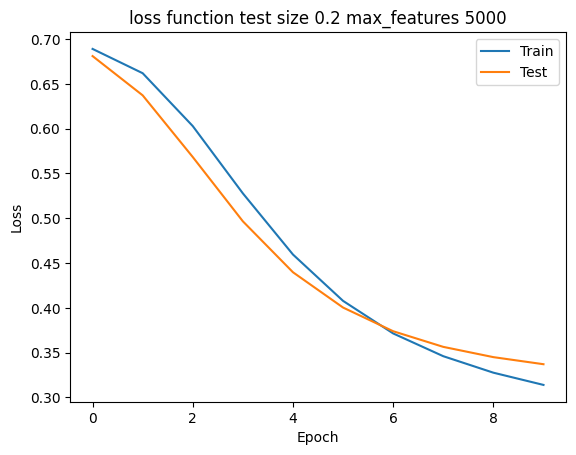

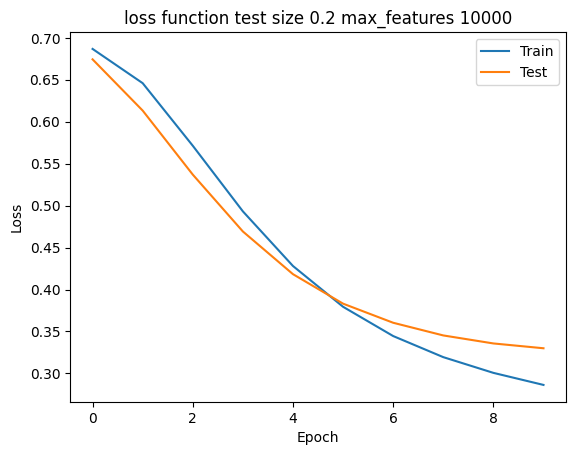

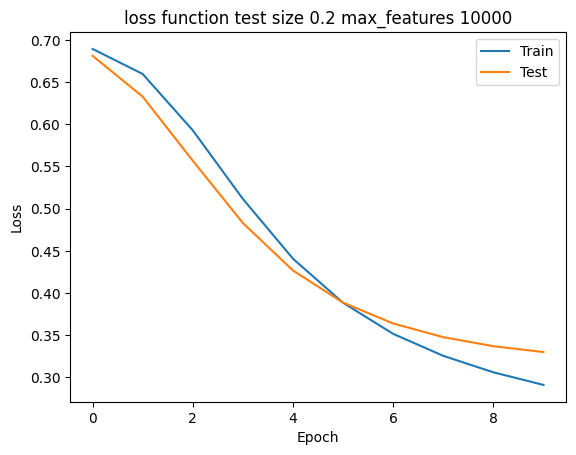

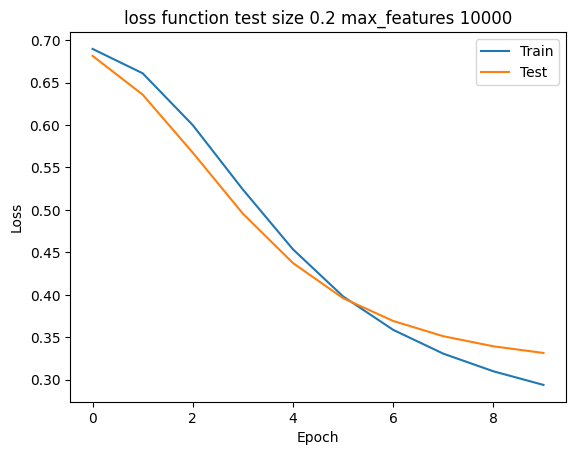

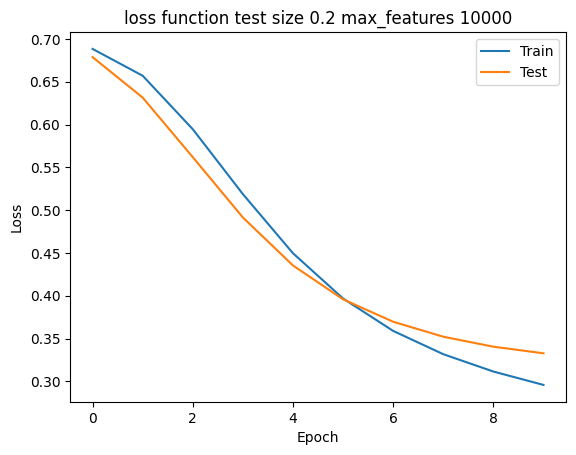

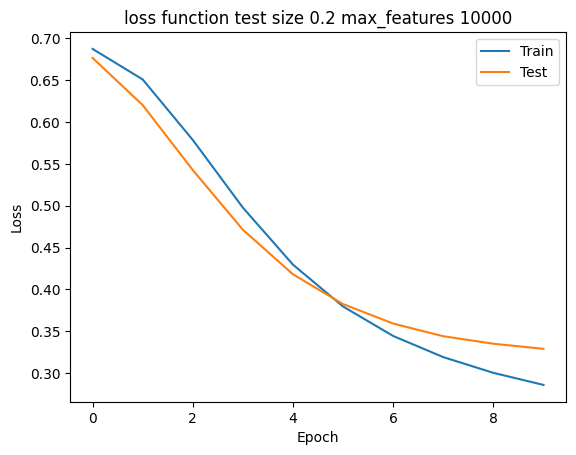

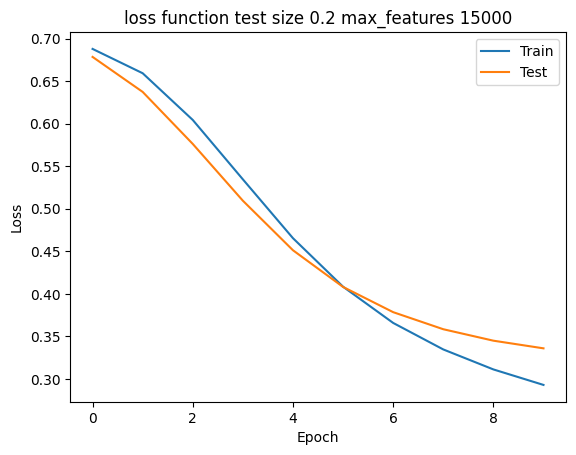

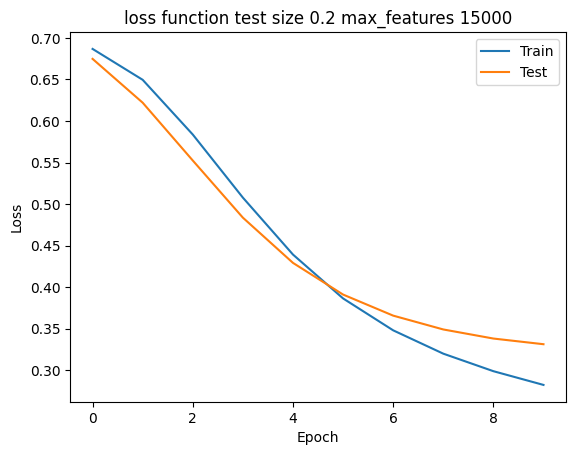

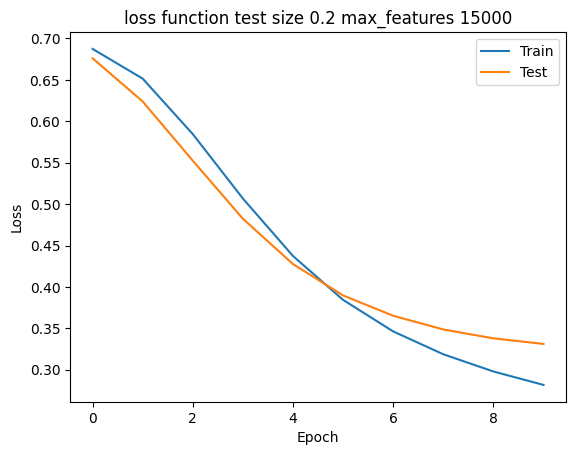

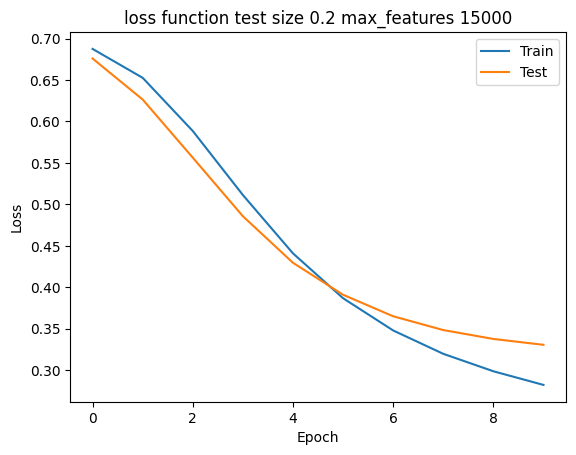

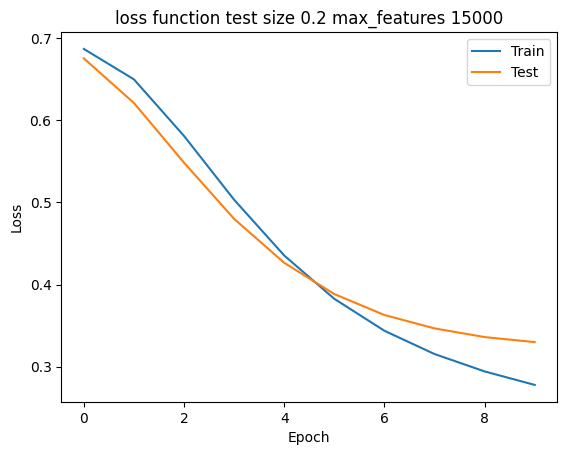

Average Score by Test Size
Test Size 0.2 & max features 5000
Average Accuracy Score : 0.8626742902999297
Average Precision Score : 0.8613895213403214
Average Recall Score : 0.8915347810084653
Average F1 Score : 0.862383972327996

Test_Size 0.2 & max features 10000
Average Accuracy Score : 0.8639783328317785
Average Precision Score : 0.8625043064391363
Average Recall Score : 0.8927861612072139
Average F1 Score : 0.8636899758880409

Test_Size 0.2 & max features 15000
Average Accuracy Score : 0.8644598254589226
Average Precision Score : 0.863484357605163
Average Recall Score : 0.892454913507545
Average F1 Score : 0.864186059021702


<Figure size 640x480 with 0 Axes>

In [9]:
df = pd.DataFrame(result, columns=['No', 'Test_Size', 'Max_Features', 'Accuracy Score', 'Precision Score', 'Recall Score', 'F1 Score', 'Loss', 'Val Loss'])
df.to_csv('hasil/baseline_BiGRU-2.csv', index=False)
loss_func(df)

# print average score by test size
print('Average Score by Test Size')
print('Test Size 0.2 & max features 5000')
print('Average Accuracy Score :', df[(df['Test_Size'] == 0.2) & (df['Max_Features'] == 5000)]['Accuracy Score'].mean())
print('Average Precision Score :', df[(df['Test_Size'] == 0.2) & (df['Max_Features'] == 5000)]['Precision Score'].mean())
print('Average Recall Score :', df[(df['Test_Size'] == 0.2) & (df['Max_Features'] == 5000)]['Recall Score'].mean())
print('Average F1 Score :', df[(df['Test_Size'] == 0.2) & (df['Max_Features'] == 5000)]['F1 Score'].mean())
print()
print('Test_Size 0.2 & max features 10000')
print('Average Accuracy Score :', df[(df['Test_Size'] == 0.2) & (df['Max_Features'] == 10000)]['Accuracy Score'].mean())
print('Average Precision Score :', df[(df['Test_Size'] == 0.2) & (df['Max_Features'] == 10000)]['Precision Score'].mean())
print('Average Recall Score :', df[(df['Test_Size'] == 0.2) & (df['Max_Features'] == 10000)]['Recall Score'].mean())
print('Average F1 Score :', df[(df['Test_Size'] == 0.2) & (df['Max_Features'] == 10000)]['F1 Score'].mean())
print()
print('Test_Size 0.2 & max features 15000')
print('Average Accuracy Score :', df[(df['Test_Size'] == 0.2) & (df['Max_Features'] == 15000)]['Accuracy Score'].mean())
print('Average Precision Score :', df[(df['Test_Size'] == 0.2) & (df['Max_Features'] == 15000)]['Precision Score'].mean())
print('Average Recall Score :', df[(df['Test_Size'] == 0.2) & (df['Max_Features'] == 15000)]['Recall Score'].mean())
print('Average F1 Score :', df[(df['Test_Size'] == 0.2) & (df['Max_Features'] == 15000)]['F1 Score'].mean())